In [20]:
import os

def find_project_root(start: Path | None = None) -> Path:
    """Return the repo root by searching upward for markers."""
    p = (start or Path.cwd()).resolve()
    markers = {".git", "environment.yml", "README.md"}
    while True:
        if any((p/m).exists() for m in markers):
            return p
        if p.parent == p:
            # fallback: use start if nothing found
            return (start or Path.cwd()).resolve()
        p = p.parent

# allow manual override via env var if needed (e.g., in CI/Colab)
ROOT = Path(os.environ.get("HBN_PROJ_ROOT", find_project_root()))
DATA_DIR     = ROOT / "data"
RESULTS_DIR  = ROOT / "results" / "eda"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", ROOT)
print("Results dir :", RESULTS_DIR)

Project root: /Users/yizj/Desktop/hbn_project
Results dir : /Users/yizj/Desktop/hbn_project/results/eda


## What each column means 
- DX_01_Cat (Category): 
Top-level DSM-5 chapter (coarse group).
    - Examples: Anxiety Disorders, Depressive Disorders, Schizophrenia Spectrum and other Psychotic Disorders, etc.
    - Use when: want stable, broad groups (best for power and simple comparisons like “any anxiety vs other”).
- DX_01_Sub (Subcategory): 
Intermediate bucket under the chapter.
    - It mixes true subtypes (Autism Spectrum Disorder, ADHD) with administrative/context flags (Past, Relational Problems).
    - Use when: rarely; it’s inconsistent for anxiety/psychosis in this dataset and often redundant with DX_01 or category.
- DX_01 (Specific diagnosis label): 
The most specific clinician consensus label (e.g., Generalized Anxiety Disorder, Social Anxiety, Panic Disorder, Schizophrenia, etc.).
    - Use when: have enough N per label and want condition-specific analysis (e.g., GAD vs Social Anxiety), or to build precise flags (e.g., “any anxiety” by keywording specific labels).
 
1. Primary outcome grouping (for power):
Use DX_01_Cat to build broad binary/multiclass targets:
- any_anxiety = 1 if DX_01_Cat == "Anxiety Disorders" or DX_01 matches anxiety labels
- any_psychosis = 1 if DX_01_Cat == "Schizophrenia Spectrum and other Psychotic Disorders" or DX_01 matches psychosis labels
- Keep a 3-way target if have enough cases: Anxiety / Psychosis / Other

2. Specific flags (secondary/ablation):
Use DX_01 to create finer flags (e.g., gad, social_anxiety, panic, specific_phobia). Run these only if each group has adequate N (say ≥100) after merging with discounting/NIH.

3.	Avoid relying on DX_01_Sub for anxiety/psychosis — it’s heterogeneous (e.g., “Past”, relational problems), so it’s not a clean diagnostic signal.

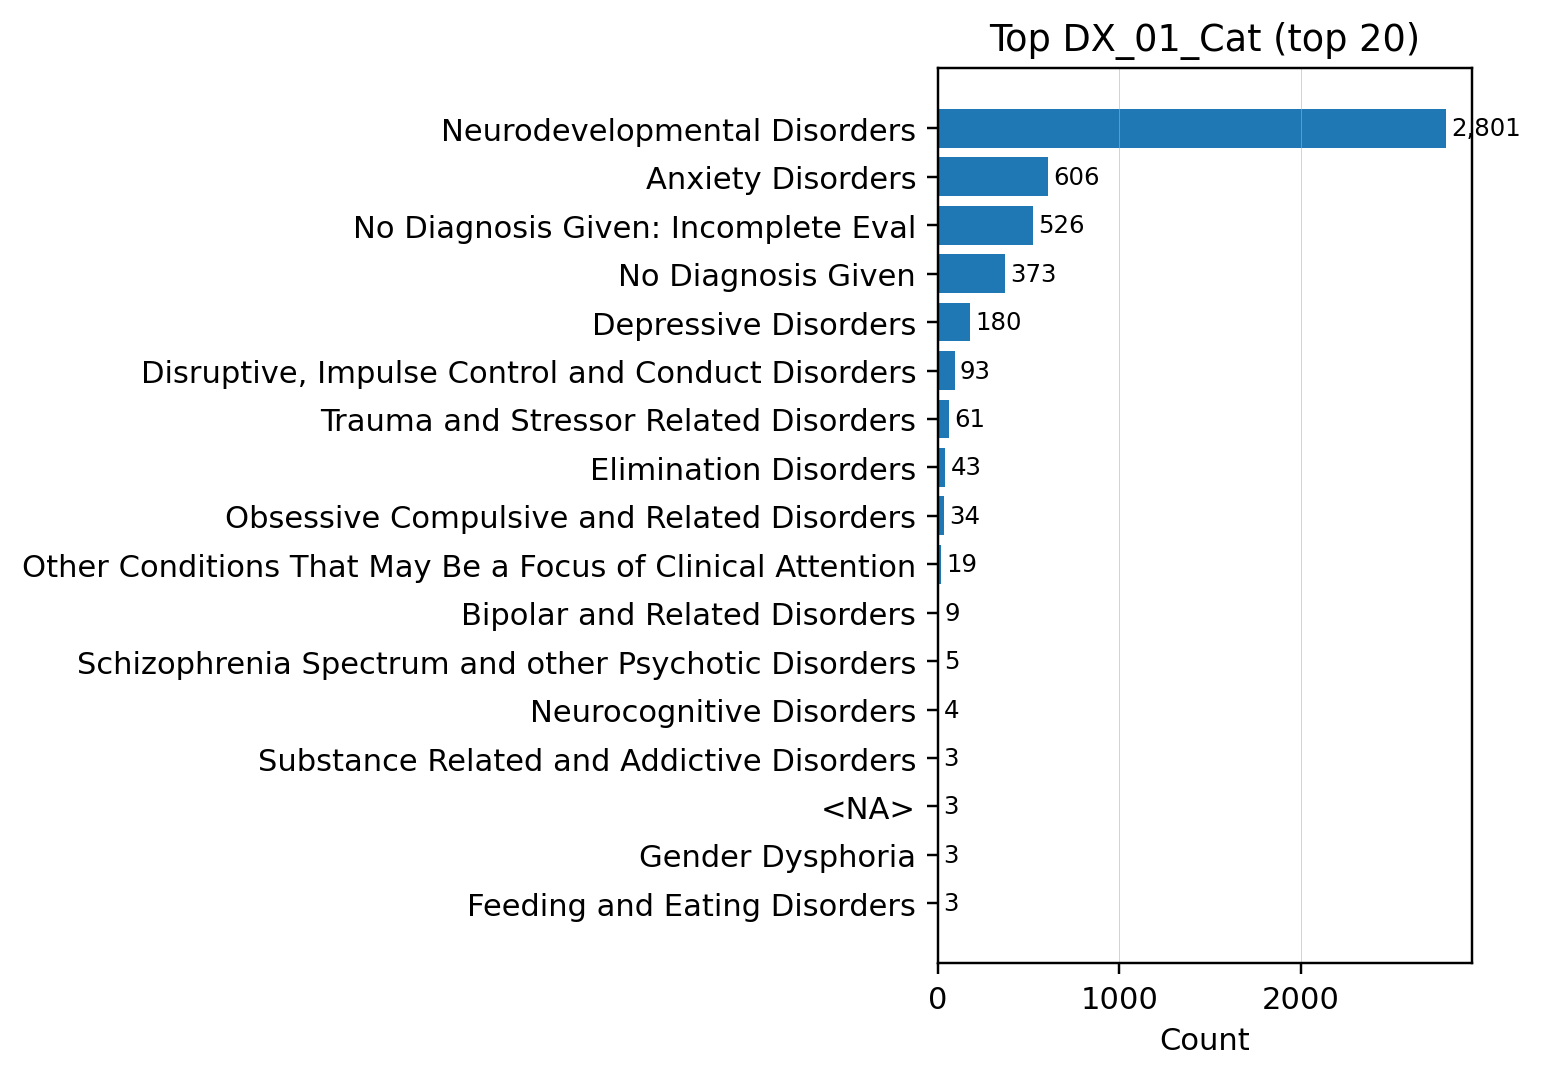

Saved: results/eda/dx01_cat_top20.png


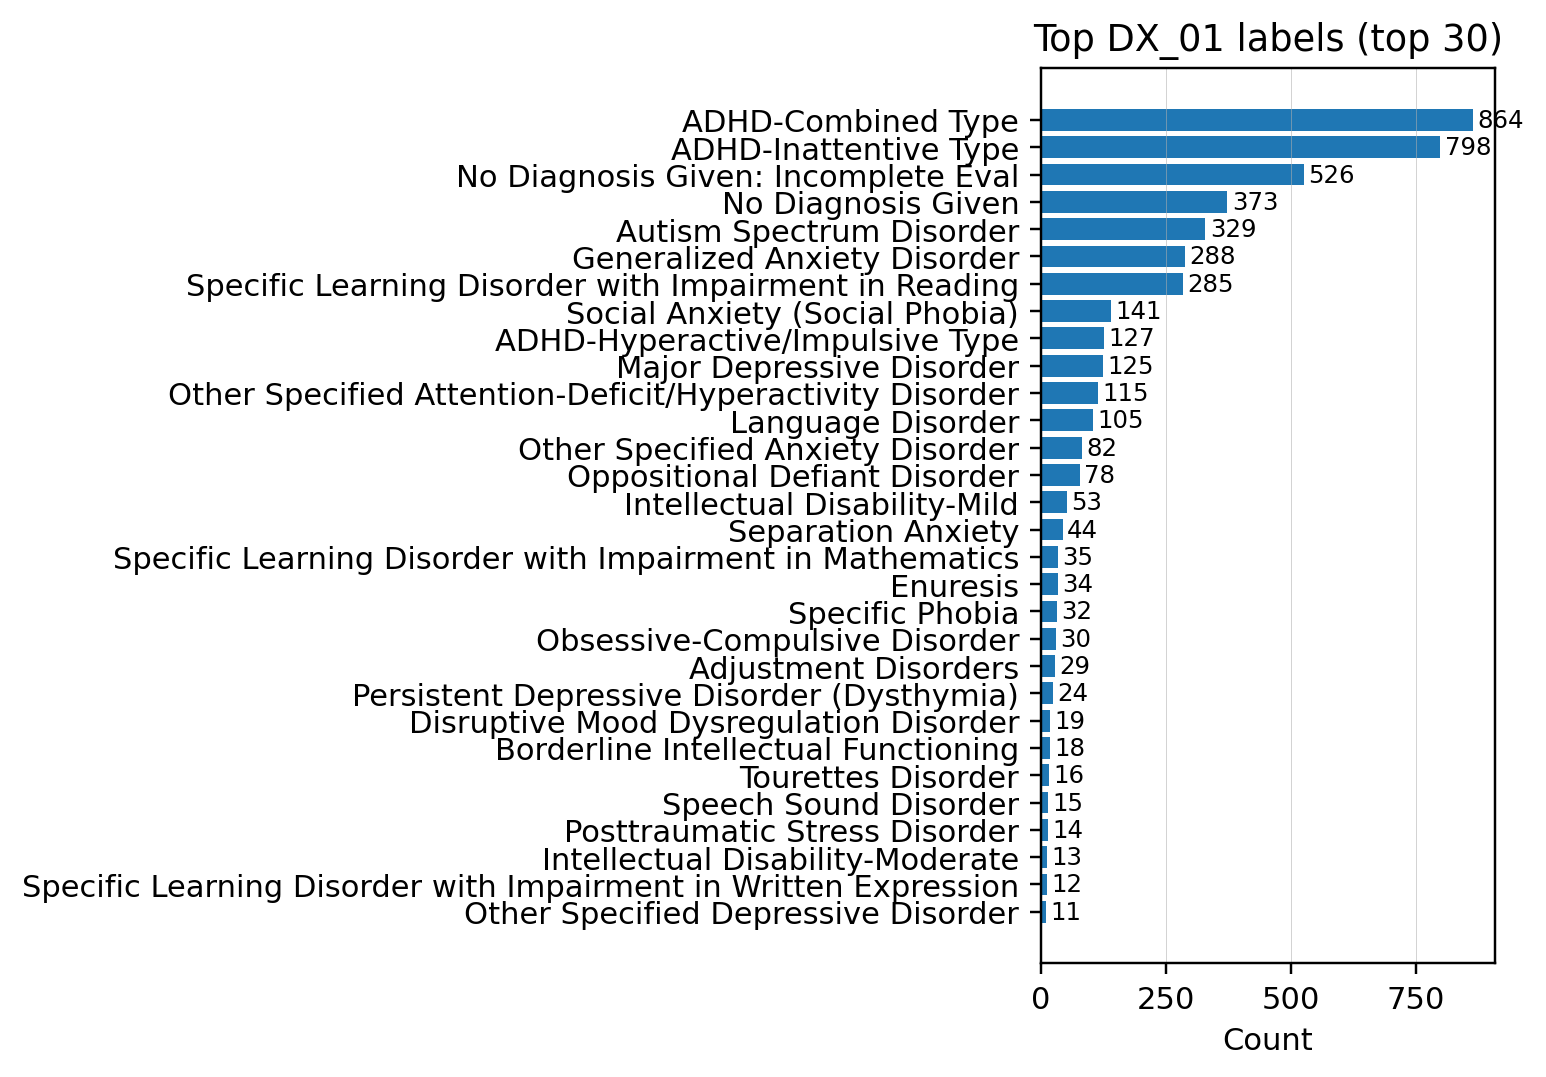

Saved: results/eda/dx01_labels_top30.png


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Columns
col_cat = "Diagnosis_ClinicianConsensus,DX_01_Cat"
col_dx  = "Diagnosis_ClinicianConsensus,DX_01"

# Output folder (relative to repo root / notebook)
outdir = Path("results/eda")
outdir.mkdir(parents=True, exist_ok=True)

def plot_top_counts(series: pd.Series, top_n: int, title: str, fname: str):
    """Horizontal bar plot with count labels; saves PNG."""
    # prep counts
    s = (series.astype("string").fillna("<NA>")
                    .value_counts(dropna=False)
                    .head(top_n))
    # plot (reverse so the largest is at the top)
    s_rev = s.iloc[::-1]
    fig, ax = plt.subplots(figsize=(7, 5), dpi=220)
    ax.barh(range(len(s_rev)), s_rev.values)
    ax.set_yticks(range(len(s_rev)))
    ax.set_yticklabels(s_rev.index)
    ax.set_xlabel("Count")
    ax.set_title(title)
    ax.grid(axis="x", linewidth=0.3, alpha=0.6)

    # add value labels at bar ends
    max_v = s_rev.values.max() if len(s_rev) else 0
    for i, v in enumerate(s_rev.values):
        ax.text(v + max(1, 0.01*max_v), i, f"{v:,}", va="center", fontsize=8)

    fig.tight_layout()
    png_path = outdir / fname
    fig.savefig(png_path, bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close(fig)
    print(f"Saved: {png_path}")

# 1) Top categories (DX_01_Cat) — bar plot with labels
plot_top_counts(df[col_cat], top_n=20,
                title="Top DX_01_Cat (top 20)",
                fname="dx01_cat_top20.png")

# 2) Top specific labels (DX_01) — bar plot with labels
plot_top_counts(df[col_dx], top_n=30,
                title="Top DX_01 labels (top 30)",
                fname="dx01_labels_top30.png")

# 3) (Optional) Small table sample of rows with missing dx_group3 (no prints)
try:
    sample_na = df.loc[df["dx_group3"].isna(), [col_cat, col_dx]].head(10)
    display(sample_na.style.hide(axis="index").set_caption("Sample rows with dx_group3 = NA"))
except KeyError:
    pass